In [5]:
import torch
import torch.nn as nn

In [6]:
device = "cuda:1"

# Volume to Triplane

In [7]:
from model.unet import (
    conv_nd,
    normalization,
    get_activation,
    zero_module,
    Upsample,
    Downsample,
    TimestepBlock,
)


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.
    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: specified, the number of out channels.
    :param use_conv: True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param dims: determines the signal is 1D, 2D, or 3D.
    :param up: True, use this block for upsampling.
    :param down: True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        dropout,
        activation,
        out_channels=None,
        use_conv=False,
        dims=2,
        up=False,
        down=False,
        dtype=None,
        scale_skip_connection=False,
    ):
        super().__init__()
        self.dtype = dtype
        self.channels = channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.scale_skip_connection = scale_skip_connection

        self.in_layers = nn.Sequential(
            normalization(channels, dtype=self.dtype),
            get_activation(activation),
            conv_nd(dims, channels, self.out_channels, 3, padding=1, dtype=self.dtype),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False, dims, dtype=self.dtype)
            self.x_upd = Upsample(channels, False, dims, dtype=self.dtype)
        elif down:
            self.h_upd = Downsample(channels, False, dims, dtype=self.dtype)
            self.x_upd = Downsample(channels, False, dims, dtype=self.dtype)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.out_layers = nn.Sequential(
            normalization(self.out_channels, dtype=self.dtype),
            get_activation(activation),
            nn.Dropout(p=dropout),
            zero_module(
                conv_nd(
                    dims,
                    self.out_channels,
                    self.out_channels,
                    3,
                    padding=1,
                    dtype=self.dtype,
                )
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = conv_nd(
                dims, channels, self.out_channels, 3, padding=1, dtype=self.dtype
            )
        else:
            self.skip_connection = conv_nd(
                dims, channels, self.out_channels, 1, dtype=self.dtype
            )

    def forward(self, x):
        """
        Apply the block to a Tensor, conditioned on a timestep embedding.
        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)

        h = self.out_layers(h)

        res = self.skip_connection(x) + h
        if self.scale_skip_connection:
            res *= 0.7071  # 1 / sqrt(2), https://arxiv.org/pdf/2104.07636.pdf
        return res

In [8]:
in_channels = 32
resblock = ResBlock(in_channels, dropout=0.0, activation="silu").to(device)
x = torch.rand(1, in_channels, 16, 16).to(device)
y = resblock(x)
y.shape

torch.Size([1, 32, 16, 16])

In [9]:
class Volume2Triplane(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        volume_size,
        sh_degree=0,
        model_channels=32,
        num_res_blocks=1,
        dropout=0.0,
    ):
        assert (
            in_channels == 3 * (sh_degree + 1) * (sh_degree + 1) + 3 + 8
        ), f"input channel is {in_channels}, but expected {3*(sh_degree+1)*(sh_degree+1)+3+8}"
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.model_channels = model_channels
        self.volume_size = volume_size
        self.num_feature_dc = 3
        if sh_degree > 0:
            self.num_feature_rest = (sh_degree + 1) * (sh_degree + 1) * 3 - 3

        self.triplane_conv_yz = nn.Conv3d(
            in_channels,
            in_channels,
            kernel_size=(volume_size, 1, 1),
            stride=(volume_size, 1, 1),
            bias=False,
        )
        self.triplane_conv_xz = nn.Conv3d(
            in_channels,
            in_channels,
            kernel_size=(1, volume_size, 1),
            stride=(1, volume_size, 1),
            bias=False,
        )
        self.triplane_conv_xy = nn.Conv3d(
            in_channels,
            in_channels,
            kernel_size=(1, 1, volume_size),
            stride=(1, 1, volume_size),
            bias=False,
        )

        self.conv_1x = nn.Conv2d(in_channels, model_channels, 3, 1, 1)
        self.conv_1y = nn.Conv2d(in_channels, model_channels, 3, 1, 1)
        self.conv_1z = nn.Conv2d(in_channels, model_channels, 3, 1, 1)

        model_x = nn.ModuleList()
        model_y = nn.ModuleList()
        model_z = nn.ModuleList()

        for i in range(num_res_blocks):
            model_x.append(ResBlock(model_channels, dropout=dropout, activation="silu"))
            model_y.append(ResBlock(model_channels, dropout=dropout, activation="silu"))
            model_z.append(ResBlock(model_channels, dropout=dropout, activation="silu"))

        self.model_x = model_x
        self.model_y = model_y
        self.model_z = model_z

        self.out_conv = nn.Conv2d(model_channels, out_channels, 3, 1, 1)

    def forward(self, x):
        B, C, H, W, D = x.shape
        yz = self.triplane_conv_yz(x)  # (B, C, 1, H, W)
        xz = self.triplane_conv_xz(x)  # (B, C, H, 1, W)
        xy = self.triplane_conv_xy(x)  # (B, C, H, W, 1)

        yz = yz.reshape(B, C, H, W)  # (B, C, H, W)
        xz = xz.reshape(B, C, H, W)  # (B, C, H, W)
        xy = xy.reshape(B, C, H, W)  # (B, C, H, W)

        yz = self.conv_1x(yz)  # (B, model_channels, H, W)
        xz = self.conv_1y(xz)  # (B, model_channels, H, W)
        xy = self.conv_1z(xy)  # (B, model_channels, H, W)

        for res_x, res_y, res_z in zip(self.model_x, self.model_y, self.model_z):
            yz = res_x(yz)  # (B, model_channels, H, W)
            xz = res_y(xz)  # (B, model_channels, H, W)
            xy = res_z(xy)  # (B, model_channels, H, W)

        x = torch.cat(
            [yz.unsqueeze(-1), xz.unsqueeze(-1), xy.unsqueeze(-1)], dim=-1
        ).permute(
            0, 4, 1, 2, 3
        )  # (B, 3, model_channels, H, W)
        x = x.reshape(B * 3, self.model_channels, H, W)  # (B*3, model_channels, H, W
        x = self.out_conv(x)  # (B*3, out_channels, H, W)
        x = x.reshape(B, 3, self.out_channels, H, W)

        return x

In [10]:
model = Volume2Triplane(59, 3, 16, 3)
model = model.to(device)

In [11]:
x = torch.rand(1, 59, 16, 16, 16)
x = x.to(device)

In [12]:
out = model(x)
print(out.shape)

torch.Size([1, 3, 3, 16, 16])


# Add classifier Net

In [13]:
import torch
from torch import nn


# Classfier
class Classfier(nn.Module):
    def __init__(self, num_labels=1000, in_features=3 * 3 * 16 * 16):
        super(Classfier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(in_features, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_labels),
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.classifier:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01**2)
                nn.init.constant_(layer.bias, val=0)
            elif isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0, std=0.01**2)
                nn.init.constant_(layer.bias, val=0)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [14]:
classfier = Classfier(216, 3 * 3 * 16 * 16)
classfier = classfier.to(device)

In [15]:
x = torch.rand(1, 59, 16, 16, 16)
x = x.to(device)

In [16]:
out = model(x)
out = classfier(out)
print(out.shape)

torch.Size([1, 216])


# Dataset and DataLoader

In [17]:
from torch.utils.data import DataLoader, Dataset
import os
import random

In [18]:
class OmniObject3D_Dataset(Dataset):
    def __init__(self, root_dir, test=False):
        super().__init__()
        self.root_dir = root_dir
        obj_names = [f for f in os.listdir(root_dir) if f.endswith(".pt")]
        classes = [f.split("_")[0] for f in obj_names]
        classes = list(set(classes))
        class_to_obj = dict()
        for obj_name in obj_names:
            class_name = obj_name.split("_")[0]
            if class_name not in class_to_obj.keys():
                class_to_obj[class_name] = []
            class_to_obj[class_name].append(os.path.join(root_dir, obj_name))

        if test:
            for class_name in class_to_obj.keys():
                class_to_obj[class_name] = class_to_obj[class_name][
                    len(class_to_obj[class_name]) * 4 // 5 :
                ]
        else:
            for class_name in class_to_obj.keys():
                class_to_obj[class_name] = class_to_obj[class_name][
                    : len(class_to_obj[class_name]) * 4 // 5
                ]
        self.classes = classes
        self.shuffle_classes = random.shuffle(self.classes.copy())
        self.class_to_obj = class_to_obj
        self.obj_names = obj_names

    def __len__(self):
        return len(self.obj_names)

    def __getitem__(self, idx):
        class_ = self.classes[idx % len(self.classes)]
        obj_path = random.choice(self.class_to_obj[class_])
        obj = torch.load(obj_path)
        target = self.classes.index(class_)
        target = torch.tensor(target)
        return obj, target

    def get_classes(self):
        return self.classes

In [19]:
train_dataset = OmniObject3D_Dataset(
    root_dir="/data/OmniObject3D/GaussianCube/4096/volume_act"
)
test_dataset = OmniObject3D_Dataset(
    root_dir="/data/OmniObject3D/GaussianCube/4096/volume_act", test=True
)

# Training

In [20]:
batch_size = 128
device = "cuda:1"
learning_rate = 1e-3
epochs = 10
data_type = torch.float32

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
model = Volume2Triplane(59, 3, 16, 3)
model = model.to(device)
classfier = Classfier(216, 3 * 3 * 16 * 16)
classfier = classfier.to(device)

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(classfier.parameters()), lr=learning_rate
)

In [24]:
training_loss_list = []
test_loss_list = []
training_acc_list = []
test_acc_list = []
for epoch in range(epochs):
    training_loss = 0
    training_accuracy = 0
    iters = 0
    for data, target in train_dataloader:
        data = data.to(device, dtype=data_type)
        target = target.to(device, dtype=torch.long)
        data = data.permute(0, 4, 1, 2, 3)

        optimizer.zero_grad()
        out = model(data)
        out = classfier(out)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            training_loss += loss.item() / out.shape[0]
            training_accuracy += (
                torch.sum(torch.argmax(out, dim=1) == target).item() / out.shape[0]
            )
            iters += 1
    training_loss /= iters
    training_accuracy /= iters
    with torch.no_grad():
        test_accuracy = 0
        test_loss = 0
        iters = 0
        for data, target in test_dataloader:
            data = data.to(device, dtype=data_type)
            target = target.to(device)
            data = data.permute(0, 4, 1, 2, 3)
            out = model(data)
            out = classfier(out)
            loss = loss_fn(out, target)
            test_loss += loss.item() / out.shape[0]
            test_accuracy += (
                torch.sum(torch.argmax(out, dim=1) == target).item() / out.shape[0]
            )
            iters += 1
        test_loss /= iters
        test_accuracy /= iters
        print(
            f"epoch: {epoch}, training_loss: {training_loss}, test_loss: {test_loss}, training_accuracy: {training_accuracy}, test_accuracy: {test_accuracy}"
        )
        training_loss_list.append(training_loss)
        test_loss_list.append(test_loss)
        training_acc_list.append(training_accuracy)
        test_acc_list.append(test_accuracy)

epoch: 0, training_loss: 0.045089925589321116, test_loss: 0.04399473546969251, training_accuracy: 0.010139627659574468, test_accuracy: 0.016123670212765957
epoch: 1, training_loss: 0.0376231987293519, test_loss: 0.04051706898040322, training_accuracy: 0.06055281155015198, test_accuracy: 0.07049455420466058
epoch: 2, training_loss: 0.030342460563736608, test_loss: 0.046651503592050184, training_accuracy: 0.20719351570415398, test_accuracy: 0.17044231256332318
epoch: 3, training_loss: 0.021513938746229193, test_loss: 0.03979089019938986, training_accuracy: 0.407223594224924, test_accuracy: 0.23267318895643366
epoch: 4, training_loss: 0.015521498275269672, test_loss: 0.04358983370112189, training_accuracy: 0.5820906155015197, test_accuracy: 0.2284384498480243
epoch: 5, training_loss: 0.011164728341210848, test_loss: 0.04347690937638645, training_accuracy: 0.6860752279635258, test_accuracy: 0.24593939969604864
epoch: 6, training_loss: 0.009141079268560734, test_loss: 0.04953030212249195, t

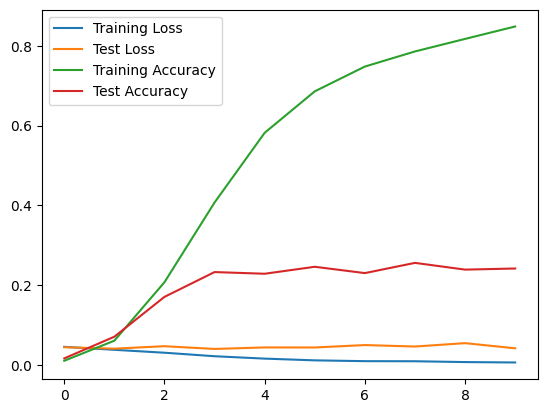

In [25]:
import matplotlib.pyplot as plt

plt.plot(training_loss_list, label="Training Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.plot(training_acc_list, label="Training Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.legend()
plt.show()